In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepweeds/labels/test_subset2.csv
/kaggle/input/deepweeds/labels/train_subset1.csv
/kaggle/input/deepweeds/labels/test_subset4.csv
/kaggle/input/deepweeds/labels/train_subset4.csv
/kaggle/input/deepweeds/labels/train_subset3.csv
/kaggle/input/deepweeds/labels/val_subset2.csv
/kaggle/input/deepweeds/labels/train_subset2.csv
/kaggle/input/deepweeds/labels/test_subset1.csv
/kaggle/input/deepweeds/labels/val_subset0.csv
/kaggle/input/deepweeds/labels/val_subset4.csv
/kaggle/input/deepweeds/labels/test_subset3.csv
/kaggle/input/deepweeds/labels/test_subset0.csv
/kaggle/input/deepweeds/labels/train_subset0.csv
/kaggle/input/deepweeds/labels/val_subset3.csv
/kaggle/input/deepweeds/labels/val_subset1.csv
/kaggle/input/deepweeds/labels/labels.csv
/kaggle/input/deepweeds/images/20171219-112552-3.jpg
/kaggle/input/deepweeds/images/20180112-091948-2.jpg
/kaggle/input/deepweeds/images/20170217-145044-0.jpg
/kaggle/input/deepweeds/images/20170217-113555-0.jpg
/kaggle/input/deepweeds/im

In [25]:
import os
import random
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [26]:
def showImage(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()


In [27]:

basePath = '/kaggle/input/deepweeds/'
imgPath = basePath + 'images/'
labelsBase = basePath + 'labels/'
labelsPath = labelsBase + 'labels.csv'
labels_df = pd.read_csv(labelsPath)

In [28]:
batch_size = 32
img_dim = 224 
epoch=10
def getImgTensor(img_d):
    return (img_d, img_d, 3)
getImgTensor(img_dim)

(224, 224, 3)

In [29]:
# Shuffle the DataFrame
shuffled_df = labels_df.sample(frac=1, random_state=23)

# Split into train, val, and test
train_size = 0.75
val_size = 0.15
test_size = 0.1

# Calculate split indices
train_end = int(train_size * len(shuffled_df))
val_end = train_end + int(val_size * len(shuffled_df))

# Split the DataFrame
df_train = shuffled_df[:train_end]
df_val = shuffled_df[train_end:val_end]
df_test = shuffled_df[val_end:]

# Reset the index for each split
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Convert 'Label' column to string (if needed)
df_train['Label'] = df_train['Label'].astype('str')
df_val['Label'] = df_val['Label'].astype('str')
df_test['Label'] = df_test['Label'].astype('str')

# Print the sizes of the splits to verify
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 13131
Validation set size: 2626
Test set size: 1752


/tmp/ipykernel_47/3939606653.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Label'] = df_train['Label'].astype('str')
/tmp/ipykernel_47/3939606653.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Label'] = df_val['Label'].astype('str')
/tmp/ipykernel_47/3939606653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [30]:
print(val_end)

15757


Label counts:
Label
8    9106
0    1125
6    1074
1    1064
4    1062
2    1031
3    1022
7    1016
5    1009
Name: count, dtype: int64


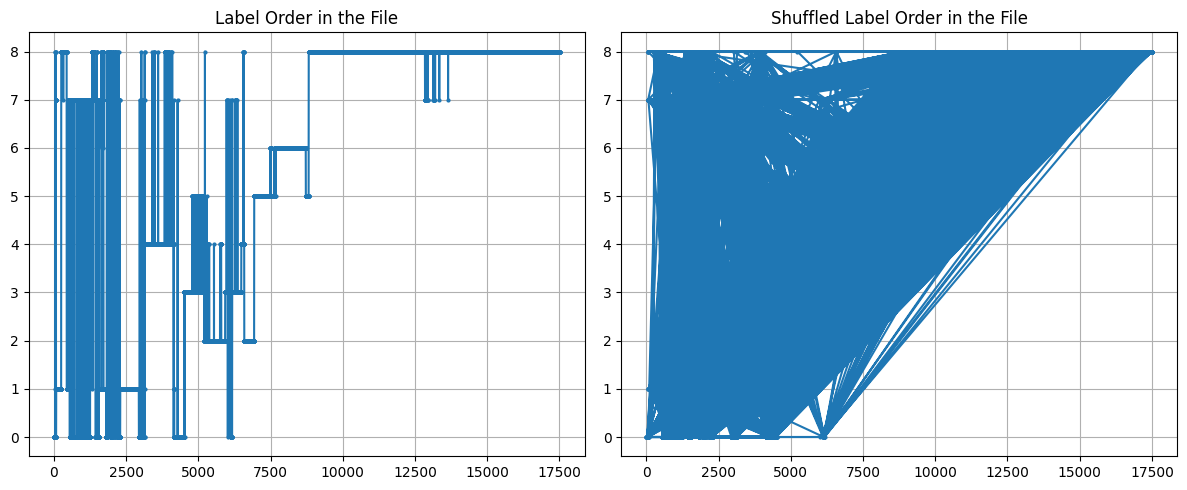

In [31]:
# Check the distribution of labels
label_counts = labels_df['Label'].value_counts()
print("Label counts:")
print(label_counts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original label order
axes[0].plot(labels_df['Label'], marker='o', linestyle='-', markersize=2)
axes[0].set_title('Label Order in the File')
axes[0].grid(True)

# Shuffled label order
axes[1].plot(shuffled_df['Label'], marker='o', linestyle='-', markersize=2)
axes[1].set_title('Shuffled Label Order in the File')
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



In [32]:
df_train.head()

Filename Label       Species
0  20170811-114143-2.jpg     0  Chinee apple
1  20170217-102914-0.jpg     0  Chinee apple
2  20170811-114743-2.jpg     0  Chinee apple
3  20171109-194758-1.jpg     5   Rubber vine
4  20180112-070517-2.jpg     8      Negative

In [33]:

# Shear transformations (shear_range=0.2), which slant the image.
# Zoom operations (zoom_range=0.2), randomly zooming in/out.
# Horizontal flipping (horizontal_flip=True) to create mirror images.

# Image Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


In [34]:
# Train Generator
train_generator = train_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_train,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=23,
    shuffle=True,
    class_mode="categorical",
    target_size=(img_dim, img_dim)
)


Found 13131 validated image filenames belonging to 9 classes.


In [35]:
# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_val,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=23,
    shuffle=False,
    class_mode="categorical",
    target_size=getImgTensor(img_dim)[:2]
)

# Test Generator
test_generator = test_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_test,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=23,
    shuffle=False,
    class_mode="categorical",
    target_size=getImgTensor(img_dim)[:2]
)

Found 2626 validated image filenames belonging to 9 classes.
Found 1752 validated image filenames belonging to 9 classes.


In [36]:
# sku.class_weight.compute_class_weight with 'balanced' mode calculates weights inversely proportional to class frequencies

class_weights = sku.class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = {i: x for i, x in enumerate(class_weights)}
print("class weights:", train_class_weights)

class weights: {0: 1.7536057692307692, 1: 1.7642079806529625, 2: 1.8850129198966408, 3: 1.8825806451612903, 4: 1.851522842639594, 5: 1.985034013605442, 6: 1.8421717171717171, 7: 1.8948051948051947, 8: 0.21336648142731793}


Batch size: 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


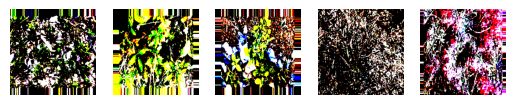

In [37]:

# images, labels = next(train_generator)
import matplotlib.pyplot as plt

# Get one batch
batch_images, batch_labels = next(train_generator)
print(f"Batch size: {batch_images.shape[0]}")

# Plot a few images from the batch
for i in range(min(5, batch_size)):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_images[i])
    plt.axis('off')
plt.show()




In [38]:

total_samples = train_generator.n #orginal images
print(f"Total number of samples: {total_samples}")
class_counts = df_train['Label'].value_counts()
print("Number of samples per class:")
print(class_counts)



Total number of samples: 13131
Number of samples per class:
Label
8    6838
0     832
1     827
6     792
4     788
3     775
2     774
7     770
5     735
Name: count, dtype: int64


**Model**

In [39]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version:", tf.__version__)

# Check if using GPU
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.experimental.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow Version: 2.18.0
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [40]:
# Add this BEFORE model creation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("❌ GPU setup error:", e)


✅ GPU memory growth enabled


In [48]:

# Load ResNet50 base model
base_model = keras.applications.ResNet50(#changeForAnotherModel
    input_shape=getImgTensor(img_dim),
    include_top=False,      
    weights='/kaggle/input/resnet-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
)

base_model.trainable = False

# Add custom layers on top
model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),  # Reduce spatial dimensions
    keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=epoch,  # Adjust as needed
    class_weight=train_class_weights,
    validation_data=val_generator  # Optional
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 180s 418ms/step - accuracy: 0.4356 - loss: 1.4809 - val_accuracy: 0.6371 - val_loss: 1.0733
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 152s 369ms/step - accuracy: 0.6347 - loss: 0.8199 - val_accuracy: 0.6573 - val_loss: 1.0384
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 155s 376ms/step - accuracy: 0.6745 - loss: 0.6947 - val_accuracy: 0.7113 - val_loss: 0.8617
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 154s 375ms/step - accuracy: 0.7026 - loss: 0.6309 - val_accuracy: 0.6398 - val_loss: 1.1265
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 154s 375ms/step - accuracy: 0.7214 - loss: 0.5705 - val_accuracy: 0.7060 - val_loss: 0.9036
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 152s 369ms/step - accuracy: 0.7340 - loss: 0.5621 - val_accuracy: 0.6820 - val_loss: 0.9701
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 154s 374ms/step - accuracy: 0.7449 - loss: 0.5206 - val_accuracy: 0.6915 - val_loss: 0.9651
Epoch 8/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 152s 370ms/step - accuracy: 0.7526 -

In [49]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.7370 - loss: 0.8052

Test accuracy: 0.7414
Test loss: 0.8101


In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
test_generator.reset()  # Important to reset generator before predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.63      0.55       102
           1       0.83      0.70      0.76        99
           2       0.80      0.84      0.82       105
           3       0.76      0.66      0.71        99
           4       0.58      0.96      0.73       104
           5       0.62      0.95      0.75       119
           6       0.61      0.87      0.72       111
           7       0.44      0.85      0.58        94
           8       0.96      0.68      0.79       919

    accuracy                           0.74      1752
   macro avg       0.68      0.79      0.71      1752
weighted avg       0.81      0.74      0.75      1752



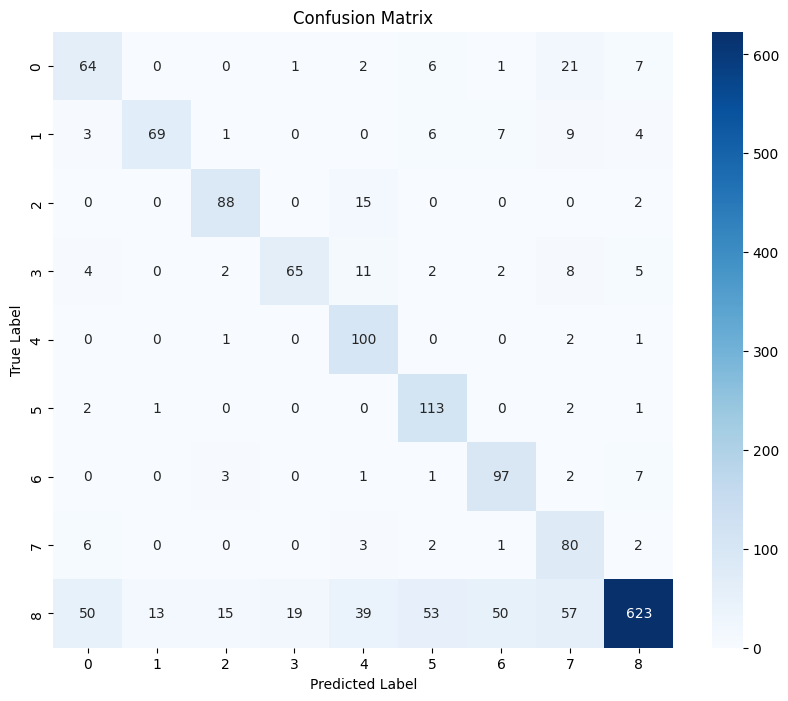

In [51]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [52]:
# Train 10 more epochs on the same model
more_epochs = 10

history_fine = model.fit(
    train_generator,
    epochs=epoch + more_epochs,      # if `epoch` was 10 before, total becomes 20
    initial_epoch=epoch,            # start from where you stopped
    class_weight=train_class_weights,
    validation_data=val_generator
)


Epoch 11/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 164s 399ms/step - accuracy: 0.7675 - loss: 0.4762 - val_accuracy: 0.7548 - val_loss: 0.7733
Epoch 12/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 150s 366ms/step - accuracy: 0.7754 - loss: 0.4519 - val_accuracy: 0.7285 - val_loss: 0.8487
Epoch 13/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 152s 369ms/step - accuracy: 0.7757 - loss: 0.4564 - val_accuracy: 0.7350 - val_loss: 0.8340
Epoch 14/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 150s 364ms/step - accuracy: 0.7777 - loss: 0.4487 - val_accuracy: 0.6935 - val_loss: 1.0426
Epoch 15/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 150s 364ms/step - accuracy: 0.7858 - loss: 0.4378 - val_accuracy: 0.7319 - val_loss: 0.8728
Epoch 16/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 151s 368ms/step - accuracy: 0.7808 - loss: 0.4132 - val_accuracy: 0.7380 - val_loss: 0.8653
Epoch 17/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 149s 363ms/step - accuracy: 0.7909 - loss: 0.4088 - val_accuracy: 0.6641 - val_loss: 1.1739
Epoch 18/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 151s 367ms/step - accuracy: 

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
test_generator.reset()  # Important to reset generator before predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       102
           1       0.59      0.95      0.73        99
           2       0.95      0.70      0.80       105
           3       0.74      0.73      0.73        99
           4       0.61      0.96      0.75       104
           5       0.83      0.81      0.82       119
           6       0.82      0.77      0.79       111
           7       0.50      0.84      0.63        94
           8       0.92      0.77      0.84       919

    accuracy                           0.78      1752
   macro avg       0.73      0.80      0.75      1752
weighted avg       0.82      0.78      0.79      1752



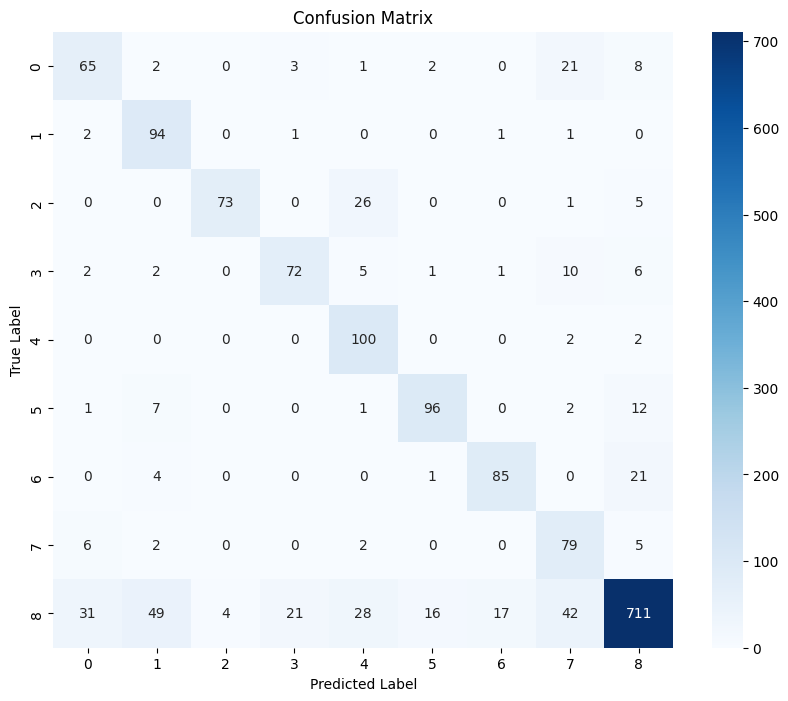

In [54]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [58]:
more_epochs = 50

# early_stop = keras.callbacks.EarlyStopping(
#     monitor='val_loss',      # or 'val_accuracy'
#     patience=10,              # epochs with no improvement before stopping
#     mode='min',              # 'min' for loss, 'max' for accuracy
#     restore_best_weights=True,  # optional: roll back to best epoch
#     verbose=1
# )
epoch=27
history_fine = model.fit(
    train_generator,
    epochs=epoch + more_epochs,   # e.g., if epoch=10, this is 60
    initial_epoch=epoch,          # continue from previous epoch
    class_weight=train_class_weights,
    validation_data=val_generator,
    # callbacks=[early_stop]
)


Epoch 28/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 161s 392ms/step - accuracy: 0.8075 - loss: 0.3717 - val_accuracy: 0.7532 - val_loss: 0.8779
Epoch 29/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 150s 366ms/step - accuracy: 0.8039 - loss: 0.3650 - val_accuracy: 0.7574 - val_loss: 0.8096
Epoch 30/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 152s 370ms/step - accuracy: 0.8152 - loss: 0.3528 - val_accuracy: 0.6622 - val_loss: 1.2357
Epoch 31/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 151s 366ms/step - accuracy: 0.8189 - loss: 0.3478 - val_accuracy: 0.7136 - val_loss: 1.0116
Epoch 32/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 153s 371ms/step - accuracy: 0.8186 - loss: 0.3556 - val_accuracy: 0.7441 - val_loss: 0.8688
Epoch 33/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 152s 369ms/step - accuracy: 0.8136 - loss: 0.3676 - val_accuracy: 0.6321 - val_loss: 1.4213
Epoch 34/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 151s 368ms/step - accuracy: 0.8205 - loss: 0.3363 - val_accuracy: 0.7152 - val_loss: 0.9975
Epoch 35/77
411/411 ━━━━━━━━━━━━━━━━━━━━ 150s 365ms/step - accuracy: 

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.68      0.53       102
           1       0.86      0.75      0.80        99
           2       0.93      0.71      0.81       105
           3       0.83      0.60      0.69        99
           4       0.64      0.94      0.76       104
           5       0.61      0.98      0.75       119
           6       0.76      0.88      0.82       111
           7       0.48      0.80      0.60        94
           8       0.94      0.74      0.83       919

    accuracy                           0.77      1752
   macro avg       0.72      0.79      0.73      1752
weighted avg       0.82      0.77      0.78      1752



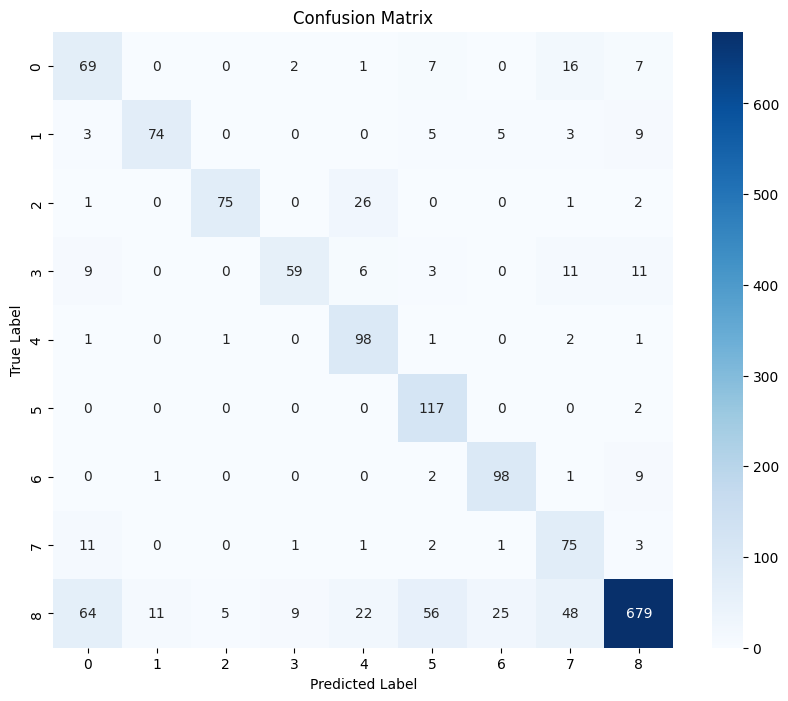

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
test_generator.reset()  # Important to reset generator before predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [60]:
model.save("deepweeds_resnet_attention.keras")

In [61]:
import numpy as np
from sklearn.metrics import (classification_report, precision_recall_fscore_support,
                             confusion_matrix, average_precision_score)
from sklearn.preprocessing import label_binarize

# 1. Get predictions and true labels from test_generator
y_true = []
y_prob = []

for batch_imgs, batch_labels in test_generator:
    probs = model.predict(batch_imgs)
    y_prob.append(probs)
    y_true.append(np.argmax(batch_labels, axis=1))
    if len(y_true) * test_generator.batch_size >= test_generator.n:
        break

y_prob = np.concatenate(y_prob, axis=0)        # shape: (N, num_classes)
y_true = np.concatenate(y_true, axis=0)        # shape: (N,)
y_pred = np.argmax(y_prob, axis=1)

# 2. Precision / Recall / F1 (per-class + macro)
print(classification_report(y_true, y_pred))

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
print("Macro Precision:", precision_macro)
print("Macro Recall:", recall_macro)
print("Macro F1:", f1_macro)

# 3. mAP@0.5 (classification analogue)
num_classes = len(test_generator.class_indices)
y_true_onehot = label_binarize(y_true, classes=range(num_classes))

ap_per_class = []
for c in range(num_classes):
    ap = average_precision_score(y_true_onehot[:, c], y_prob[:, c])
    ap_per_class.append(ap)
mAP = np.mean(ap_per_class)
print("mAP (macro over classes):", mAP)

# 4. IoU per class and mean IoU (from confusion matrix)
cm = confusion_matrix(y_true, y_pred)
ious = []
for c in range(num_classes):
    tp = cm[c, c]
    fp = cm[:, c].sum() - tp
    fn = cm[c, :].sum() - tp
    denom = tp + fp + fn
    iou = tp / denom if denom > 0 else 0.0
    ious.append(iou)
mean_iou = np.mean(ious)
print("Mean IoU:", mean_iou)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

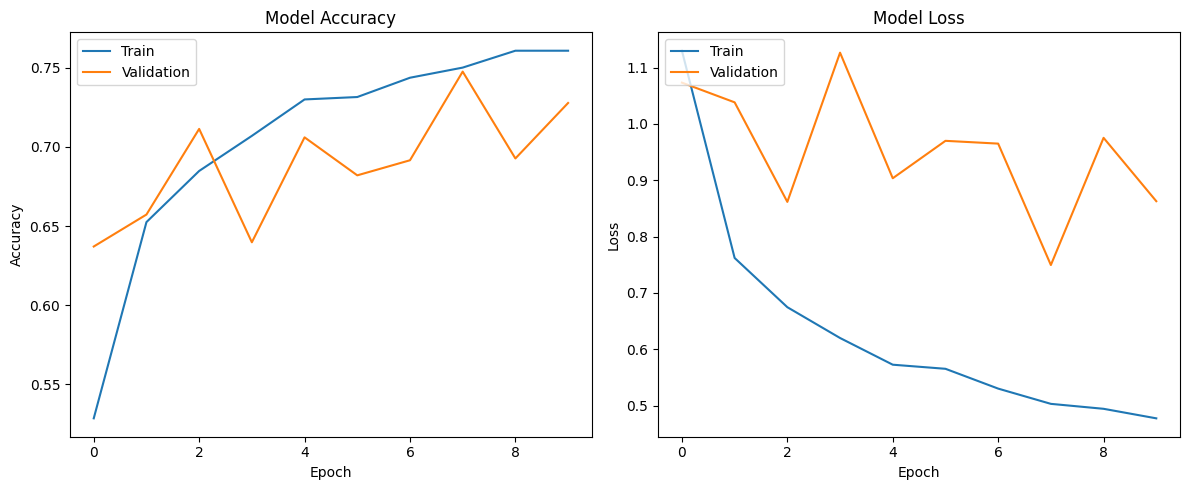

In [62]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

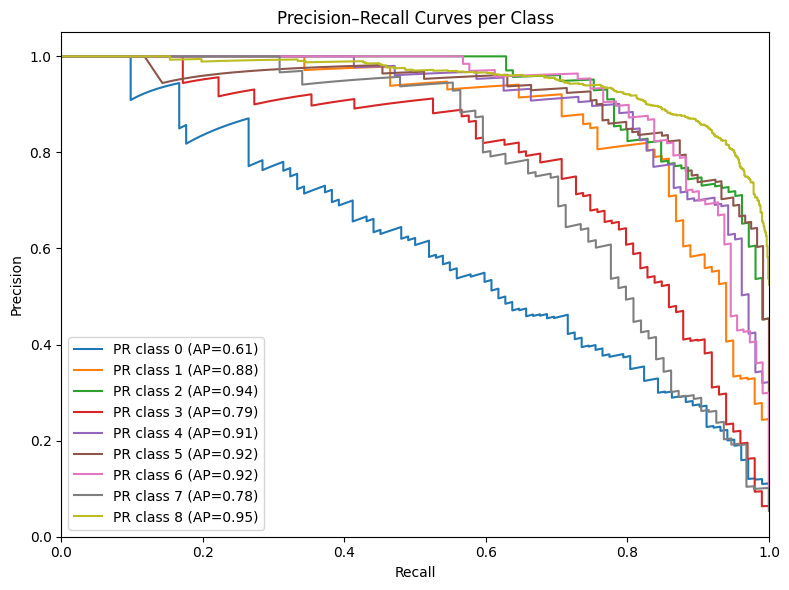

In [69]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())
n_classes = len(class_labels)

# 1) Get probabilities and true labels
y_true = []
y_prob = []

for batch_imgs, batch_labels in test_generator:
    probs = model.predict(batch_imgs)
    y_prob.append(probs)
    y_true.append(np.argmax(batch_labels, axis=1))
    if len(y_true) * test_generator.batch_size >= test_generator.n:
        break

y_prob = np.concatenate(y_prob, axis=0)          # (N, num_classes)
y_true = np.concatenate(y_true, axis=0)          # (N,)

# 2) Binarize true labels
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))  # (N, num_classes)

# 3) Compute PR + AP per class
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_test_bin[:, i], y_prob[:, i]      # use probs, not argmax
    )
    average_precision[i] = average_precision_score(
        y_test_bin[:, i], y_prob[:, i]
    )

# 4) Plot
colors = plt.cm.tab10.colors  # or any color list

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(
        recall[i], precision[i], color=color,
        label=f'PR class {class_labels[i]} (AP={average_precision[i]:0.2f})'
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision–Recall Curves per Class')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [71]:
#inference 
import time
import tensorflow as tf

# choose device: "/CPU:0" or "/GPU:0"
device = "/GPU:0"   # or "/CPU:0" for CPU numbers

# warm-up
for _ in range(5):
    _ = model.predict(next(test_generator)[0])

# measure
n_batches = 50    # adjust or use full test set
total_images = 0
start = time.time()

with tf.device(device):
    test_generator.reset()
    for i, (batch_imgs, _) in enumerate(test_generator):
        _ = model.predict(batch_imgs)
        total_images += batch_imgs.shape[0]
        if i + 1 >= n_batches or total_images >= test_generator.n:
            break

elapsed = time.time() - start
latency_ms = (elapsed / total_images) * 1000.0

print(f"Device: {device}, Images: {total_images}")
print(f"Average latency: {latency_ms:.2f} ms/image")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [76]:
# collect indices where model failed
mis_idx = np.where(y_true != y_pred)[0]
# Get class names from generator
class_names = list(test_generator.class_indices.keys())
# or, if you only have train_generator:
# class_names = list(train_generator.class_indices.keys())

# pick 8 diverse failures
sample_idx = mis_idx[:8]   # or np.random.choice(mis_idx, 8, replace=False)

# get file paths from your test generator / dataframe
# assuming you have a dataframe `df_test` aligned with generator order:
failed_files = [df_test.iloc[i]["Filename"] for i in sample_idx]
true_labels = [class_names[y_true[i]] for i in sample_idx]
pred_labels = [class_names[y_pred[i]] for i in sample_idx]


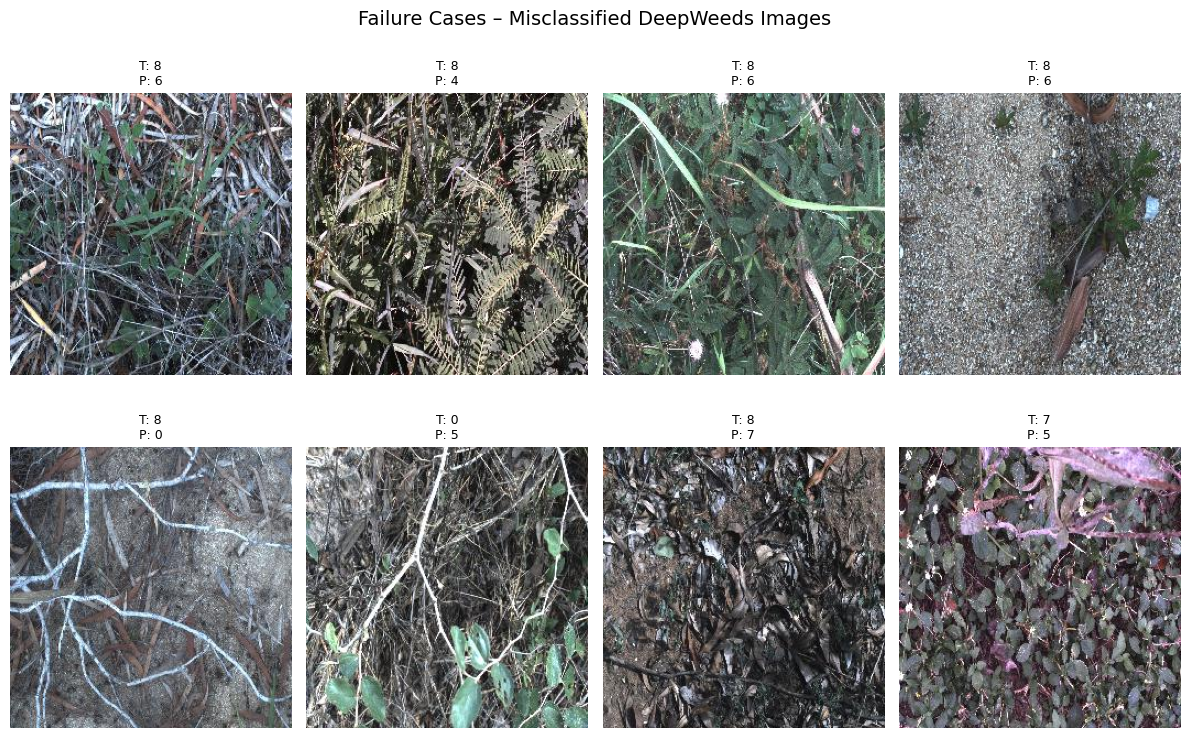

In [77]:
import matplotlib.pyplot as plt
import cv2
import os
test_image_root = imgPath 
plt.figure(figsize=(12, 8))
for k, idx in enumerate(sample_idx):
    img_path = os.path.join(test_image_root, df_test.iloc[idx]["Filename"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, k+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_labels[k]}\nP: {pred_labels[k]}", fontsize=9)
plt.suptitle("Failure Cases – Misclassified DeepWeeds Images", fontsize=14)
plt.tight_layout()
plt.show()


In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def apply_distortions_tensor_level(img):
    """
    img: single image from test_generator (float32, 0–1, RGB)
    Apply ultra-soft distortions directly in tensor space.
    """
    distortions = {}

    # original (no change)
    distortions["original"] = img.copy()

    # 1) Low-light: -2% brightness
    low_light = np.clip(img * 0.98, 0.0, 1.0)
    distortions["low_light"] = low_light

    # 2) Overexposure: +2% brightness
    overexp = np.clip(img * 1.02, 0.0, 1.0)
    distortions["overexposure"] = overexp

    # 3) Cool temp: +2% blue channel
    cool = img.copy()
    cool[..., 2] = np.clip(cool[..., 2] * 1.02, 0.0, 1.0)  # assuming channels: R,G,B
    distortions["cool_temp"] = cool

    # 4) Warm temp: +2% red channel
    warm = img.copy()
    warm[..., 0] = np.clip(warm[..., 0] * 1.02, 0.0, 1.0)
    distortions["warm_temp"] = warm

    # 5) Motion blur: light average of neighbors using small kernel
    # implement as simple 3x3 average filter
    from scipy.ndimage import uniform_filter
    motion_blur = uniform_filter(img, size=(3, 3, 1))
    distortions["motion_blur"] = motion_blur

    return distortions


In [103]:
test_batch = next(test_generator)[0][:20]  # shape: (20, H, W, 3), already 0–1 floats
results = []

for i, img in enumerate(test_batch):
    orig_pred = np.argmax(model.predict(img[None, ...], verbose=0))

    distortions = apply_distortions_tensor_level(img)

    for cond, dist_img in distortions.items():
        dist_pred = np.argmax(model.predict(dist_img[None, ...], verbose=0))
        results.append({
            "image_idx": i,
            "condition": cond,
            "true_label": orig_pred,
            "pred_label": dist_pred,
            "correct": orig_pred == dist_pred,
        })

df_results = pd.DataFrame(results)
acc = df_results.groupby("condition")["correct"].agg(["mean","count"])
acc["accuracy_%"] = (acc["mean"]*100).round(1)
print(acc[["accuracy_%","count"]])


              accuracy_%  count
condition                      
cool_temp           45.0     20
low_light           10.0     20
motion_blur         65.0     20
original           100.0     20
overexposure        10.0     20
warm_temp           55.0     20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


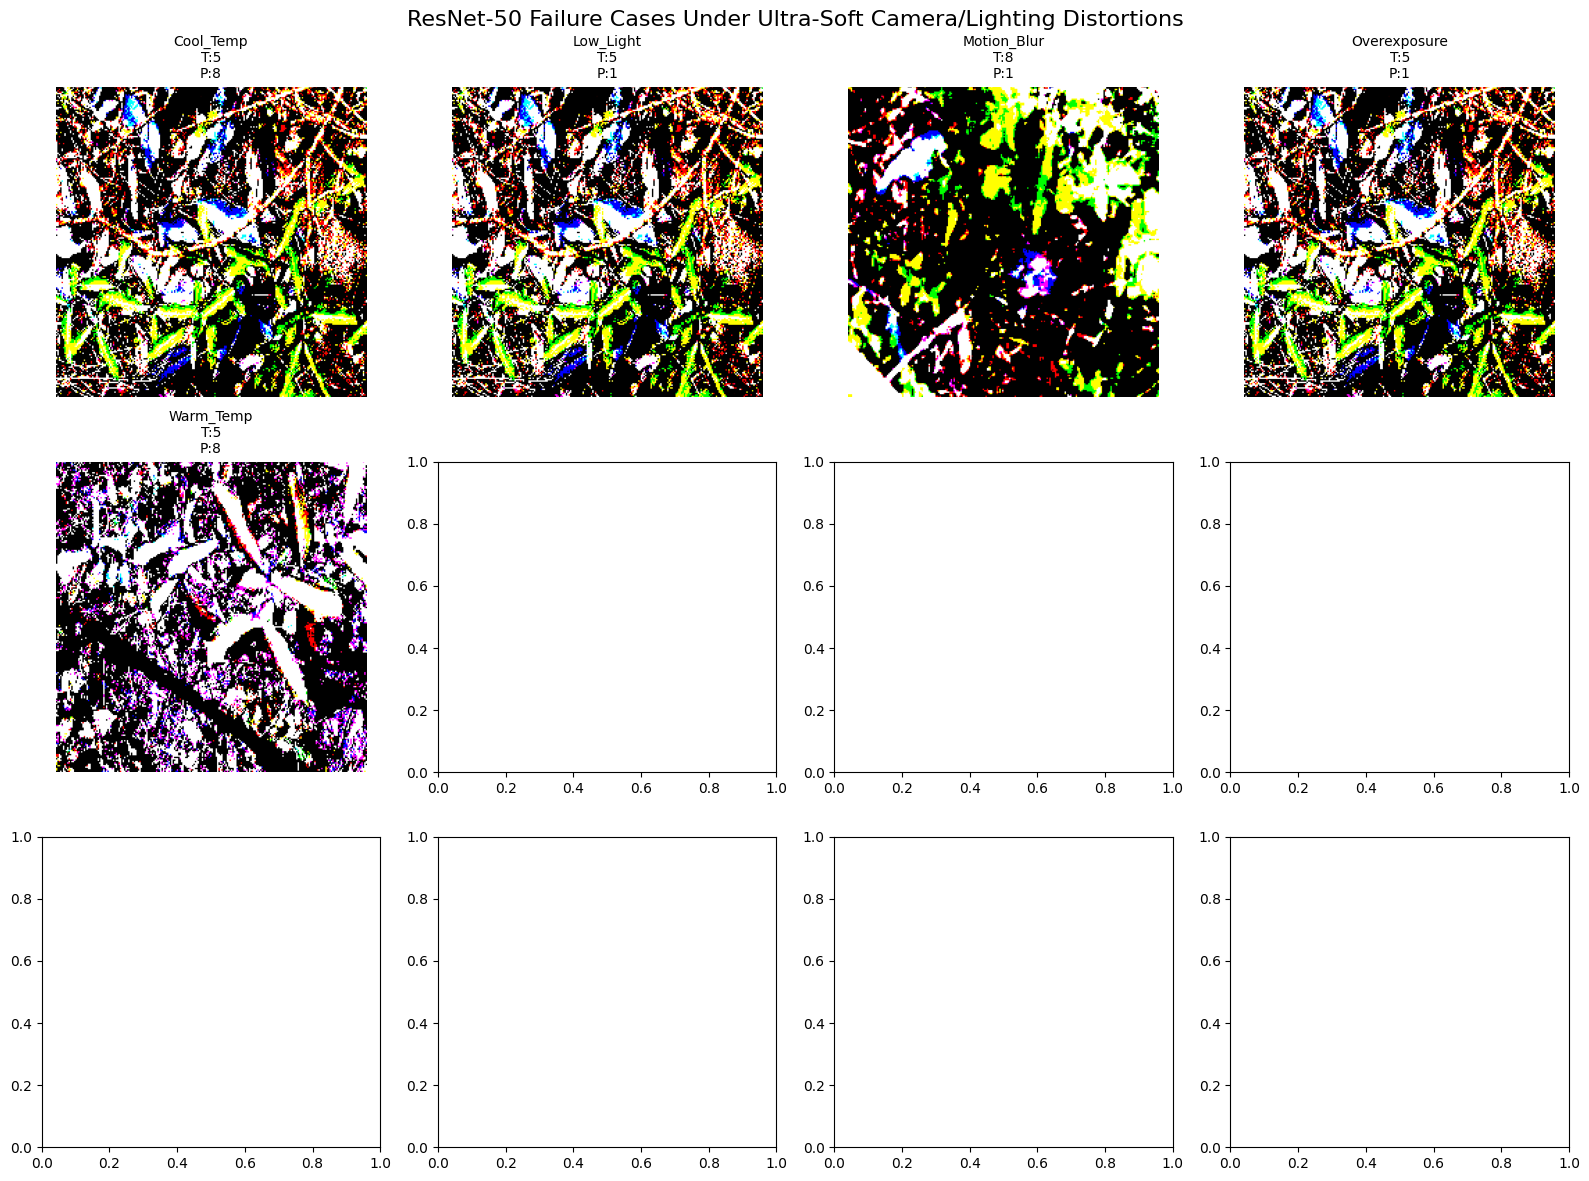

In [106]:
class_names = list(test_generator.class_indices.keys())

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, (cond, group) in enumerate(df_results[df_results["correct"] == False].groupby("condition")):
    if i >= 12:
        break
    sample = group.iloc[0]
    idx = sample["image_idx"]
    orig_img = test_batch[idx]
    dist_img = apply_distortions_tensor_level(orig_img)[sample["condition"]]

    axes[i].imshow(dist_img)
    axes[i].set_title(
        f"{sample['condition'].title()}\nT:{class_names[sample['true_label']]}\nP:{class_names[sample['pred_label']]}",
        fontsize=10,
    )
    axes[i].axis("off")

plt.suptitle("ResNet-50 Failure Cases Under Ultra-Soft Camera/Lighting Distortions", fontsize=16)
plt.tight_layout()
plt.savefig("figure4_camera_failures.png", dpi=150, bbox_inches="tight")
plt.show()
